## Probabilistic Piano Fingering Prediction with Hidden Markov Models

## 1. Abstract

Determining optimal fingerings for piano music is a complex, cognitively demanding task that is crucial for performance. This project explores the application of a generative probabilistic model, the Hidden Markov Model (HMM), for predicting piano fingerings. Building upon previous work that established baselines using discriminative models like Random Forest (86% accuracy), RNN (51%), and LSTM (73%), this code implements an HMM to model the sequential nature of fingering choices. HMM was chosen for its inherent ability to handle temporal sequences.

## 2. Dataset and Preprocessing

Same as in previous work: 43 fingering-annotated MusicXML piano scores from Musescore.com.

*   Total Notes: ~39,000
*   Annotated Notes: ~16,000 (for both hands)
*   Features Extracted: Note pitch (as a MIDI number), chord information, and rest information.

Preprocessing & HMM Setup:

1. Hand Selection: right-hand only as common in fingering prediction research.
2. Segmentation: Rests split sequences; single-note phrases discarded.
3. Data Split: 80% training (MIDI sequences + lengths), 20% testing (includes ground-truth fingerings).

Model Components:

* Hidden States (N): Right-hand fingers {1, 2, 3, 4, 5}
* Observations (M): MIDI pitches [1–108]
* HMM Parameters (λ):

  1. π (Initial Probabilities): Likelihood of starting a phrase with each finger, estimated from first finger use after rests.
  2. A (Transition Matrix): 5×5 matrix, counts of consecutive finger pairs.
  3. B (Emission Matrix): 5×108 matrix, frequency of each finger playing each MIDI note.

Trained Models:

* HMM without Priors: All parameters learned via Baum-Welch.
* HMM with Priors: Initialized using empirically estimated π, A, and B.

Inference: Most likely fingering sequence predicted via the Viterbi algorithm.

In [2]:
# @title 3. Upload training records CSV file
from google.colab import files
file = files.upload()

Saving paino_fingering.csv to paino_fingering.csv


In [3]:
# Load the dataset from the uploaded file
try:
    df = pd.read_csv('paino_fingering.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'paino_fingering.csv' not found.")


# Let's focus on right hand only
df = df[df['hand'] == 0]

df

Dataset loaded successfully.


,title,note,pitch,fingering,is_chord,is_rest,hand,finger
0,data/Fur_Elise_Easy.mxl,E5,76,4,False,False,0,4
1,data/Fur_Elise_Easy.mxl,D#5,75,3,False,False,0,3
2,data/Fur_Elise_Easy.mxl,E5,76,0,False,False,0,0
3,data/Fur_Elise_Easy.mxl,D#5,75,0,False,False,0,0
4,data/Fur_Elise_Easy.mxl,E5,76,0,False,False,0,0
...,...,...,...,...,...,...,...,...
30648,data/Fr_Elise_Original_wider_layout_with_finge...,C5,72,0,False,False,0,0
30649,data/Fr_Elise_Original_wider_layout_with_finge...,B4,71,0,False,False,0,0
30650,data/Fr_Elise_Original_wider_layout_with_finge...,C4,60,1,True,False,0,1
30651,data/Fr_Elise_Original_wider_layout_with_finge...,A4,69,3,True,False,0,3



Shape of the final DataFrame: (5, 109)


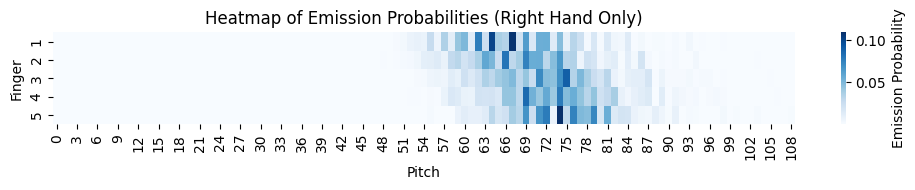

In [4]:
# @title 4. Estimate emission probabilities priors

# First, clean the data and define the full range of observed pitches.
# Coerce 'pitch' column to a numeric type. Invalid strings become NaN.
df['pitch'] = pd.to_numeric(df['pitch'], errors='coerce')


# Filter out rows where finger is 0 or pitch is not a valid number.
df_filtered = df[(df['finger'] != 0) & (df['pitch'].notna())].copy()
df_filtered['pitch'] = df_filtered['pitch'].astype(int)

finger_pitch_counts_observed = pd.crosstab(df_filtered['finger'], df_filtered['pitch'])


# Reindex the DataFrame to include all observed pitches from the entire dataset.
# The `fill_value=0` argument ensures that any pitch a finger never played gets a count of 0.
finger_pitch_counts = finger_pitch_counts_observed.reindex(
    columns=range(109),
    fill_value=0
)

# Calculate the total number of times each finger was used.
finger_counts = df_filtered['finger'].value_counts()

# Compute the emission probabilities by dividing the finger-pitch counts by the total finger counts.
emission_probabilities = finger_pitch_counts.div(finger_counts, axis=0).fillna(0)

# Smoothing, to remove zeros
epsilon = 1e-6
emissionprob_prior = emission_probabilities.to_numpy() + epsilon
emissionprob_prior /= emissionprob_prior.sum(axis=1, keepdims=True)

print(f"\nShape of the final DataFrame: {emissionprob_prior.shape}")

plt.figure(figsize=(10, 2))
cmap = plt.get_cmap("Blues")
cmap.set_bad(color='white')
heatmap = sns.heatmap(
    emissionprob_prior,
    cmap=cmap,
    cbar_kws={'label': 'Emission Probability'},
    yticklabels=np.arange(1, 6)
)

plt.title('Heatmap of Emission Probabilities (Right Hand Only)', fontsize=12)
plt.xlabel('Pitch', fontsize=10)
plt.ylabel('Finger', fontsize=10)
plt.tight_layout()
plt.show()

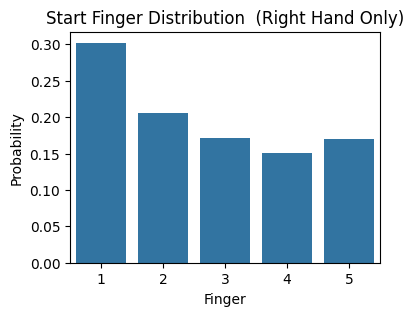

In [5]:
# @title 5. Estimate start probability prior

# Condition 1: First finger in each title.
# We use groupby() and cumcount() to identify the first row of each title group.
is_first_finger = df.groupby('title').cumcount() == 0

# Condition 2: Finger immediately following a rest.
# We shift the 'is_rest' column to check the value of 'is_rest' in the preceding row.
is_after_rest = df['is_rest'].shift(1, fill_value=False)

# Condition 3: Finger is not 0
is_not_zero = df['finger'] != 0

# A finger is selected if it's the first in a title OR it follows a rest, AND it is not zero.
final_mask = (is_first_finger | is_after_rest) & is_not_zero

# Apply the mask to get the filtered fingers
filtered_fingers = df.loc[final_mask, 'finger']

# Calculate the distribution of the filtered fingers
finger_distribution = filtered_fingers.value_counts()

finger_counts = filtered_fingers.value_counts()

# Normalize the counts to get probabilities by dividing by the total number of fingers.
start_prob = finger_counts / finger_counts.sum()

# Reindex the probabilities Series. This ensures that the resulting array has a
# position for every finger from 1 up to the maximum finger number observed.
# Any finger not present in the filtered data will have a probability of 0.
max_finger = start_prob.index.max()
start_prob = start_prob.reindex(range(1, max_finger + 1), fill_value=0)

startprob_prior = start_prob.to_numpy()

plt.figure(figsize=(4, 3))
bar_plot = sns.barplot(
    x=start_prob.index,
    y=start_prob.values,
)

plt.title('Start Finger Distribution  (Right Hand Only)', fontsize=12)
plt.xlabel('Finger', fontsize=10)
plt.ylabel('Probability', fontsize=10)

plt.show()

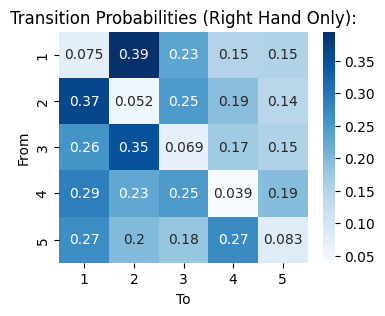

In [6]:
# @title 6. Estimate transition probability prior

# Self-join by shifting the dataframe
df['finger_next'] = df['finger'].shift(-1)

# Drop the last row as it will have a NaN for the 'finger_next' column
df_joined = df.dropna().copy()

# Convert to integer type, as shift can introduce floats
df_joined['finger_next'] = df_joined['finger_next'].astype(int)

# Filter for cases where both 'finger' and 'finger_next' are greater than 0
filtered_df = df_joined[(df_joined['finger'] > 0) & (df_joined['finger_next'] > 0)]

# Compute the transition matrix
transition_matrix = pd.crosstab(filtered_df['finger'], filtered_df['finger_next'])

# Normalize the transition matrix to get probabilities
normalized_transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
transmat_prior = normalized_transition_matrix.to_numpy()

plt.figure(figsize=(4, 3))
sns.heatmap(normalized_transition_matrix, annot=True,  cmap='Blues', xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
plt.title('Transition Probabilities (Right Hand Only):', fontsize = 12)
plt.xlabel('To', fontsize = 10)
plt.ylabel('From', fontsize = 10)
plt.show()

In [8]:
# @title 7. Generate sequences

# We are splitting scores by title and rests:
df['phrase_id'] = df.groupby('title')['is_rest'].cumsum()
df['unique_phrase_id'] = df['title'] + '_' + df['phrase_id'].astype(str)

# Drop rows where is_rest is True to exclude rests from our sequences.
df_notes = df[df['is_rest'] == False].copy()

# Find the length of each sequence.
sequence_lengths_series = df_notes.groupby('unique_phrase_id').size()

# Compute how many sequences have a length of 1 (or less).
num_sequences_short = (sequence_lengths_series <= 1).sum()

# Identify the phrases that have a length greater than 1.
phrases_to_keep = sequence_lengths_series[sequence_lengths_series > 1].index.tolist()

# Drop short sequences by filtering the DataFrame.
df_final = df_notes[df_notes['unique_phrase_id'].isin(phrases_to_keep)]


# Split the list of unique phrase IDs into training and testing sets.
test_set_size = 0.2
train_ids, test_ids = train_test_split(
    phrases_to_keep,
    test_size=test_set_size,
    random_state=171717
)

# Generate Training Dataset
train_df = df_final[df_final['unique_phrase_id'].isin(train_ids)]
train_pitch_sequences = train_df.groupby('unique_phrase_id')['pitch'].apply(list).tolist()
train_lengths = train_df.groupby('unique_phrase_id').size().tolist()


# Generate Testing Dataset (with finger sequences)
test_df = df_final[df_final['unique_phrase_id'].isin(test_ids)]
test_pitch_sequences = test_df.groupby('unique_phrase_id')['pitch'].apply(list).tolist()
test_finger_sequences = test_df.groupby('unique_phrase_id')['finger'].apply(list).tolist()
test_lengths = test_df.groupby('unique_phrase_id').size().tolist()


train_pitches_flat = [pitch for seq in train_pitch_sequences for pitch in seq]
X_train = np.array(train_pitches_flat).reshape(-1, 1)

test_pitches_flat = [pitch for seq in test_pitch_sequences for pitch in seq]
X_test = np.array(test_pitches_flat).reshape(-1, 1)

test_fingers_flat = [finger for seq in test_finger_sequences for finger in seq]
y_test_true_flat = np.array(test_fingers_flat)



# Print the results for verification
print("--- Data Split Summary ---")
print(f"Total sequences kept: {len(phrases_to_keep)}")
print(f"Training sequences:   {len(train_ids)} (totaling {len(X_train)} notes)")
print(f"Testing sequences:    {len(test_ids)} (totaling {len(X_test)} notes)")


print("\n--- Human-Readable Sample of Test Data (Before Flattening) ---")
# Print a sample before flattening to show the alignment is correct
for i in range(min(2, len(test_ids))):
    print(f"\nTest Sample #{i+1}")
    print(f"  Pitches:  {test_pitch_sequences[i]}")
    print(f"  Fingers:  {test_finger_sequences[i]}")
    print(f"  Length:   {test_lengths[i]}")

print("\n--- Final NumPy Arrays for Model ---")
print(f"Shape of training pitch data (X_train): {X_train.shape}")
print(f"Shape of testing pitch data (X_test):   {X_test.shape}")
print(f"Shape of true test finger data (y_test_true_flat): {y_test_true_flat.shape}")

--- Data Split Summary ---
Total sequences kept: 885
Training sequences:   708 (totaling 11344 notes)
Testing sequences:    177 (totaling 3632 notes)

--- Human-Readable Sample of Test Data (Before Flattening) ---

Test Sample #1
  Pitches:  [74, 72]
  Fingers:  [5, 0]
  Length:   2

Test Sample #2
  Pitches:  [64, 62, 64, 72, 69, 64, 62, 67, 66, 72, 71, 64]
  Fingers:  [0, 0, 0, 0, 4, 2, 1, 3, 1, 5, 4, 0]
  Length:   12

--- Final NumPy Arrays for Model ---
Shape of training pitch data (X_train): (11344, 1)
Shape of testing pitch data (X_test):   (3632, 1)
Shape of true test finger data (y_test_true_flat): (3632,)


In [9]:
# --- HMM Model Definition ---
# As per the proposal, we use a CategoricalHMM since our observations (MIDI pitches) are discrete values.
# The model will have 5 hidden states, corresponding to the 5 fingers.

# First verion of the model without priors
model = hmm.CategoricalHMM(n_components=5, n_iter=1000, tol=1e-4, random_state=17, verbose=True)
# model.transmat_ = model.transmat_prior
# model.startprob_ = model.startprob_prior
# model.emissionprob_ = emissionprob_prior

# Train the HMM model
print("Training the Hidden Markov Model...")
model.fit(X_train, train_lengths)

Training the Hidden Markov Model...


         1  -54362.58057323             +nan
         2  -38547.95882226  +15814.62175098
         3  -38062.37843675    +485.58038551
         4  -37578.84755302    +483.53088373
         5  -36809.83517211    +769.01238091
         6  -36072.44087256    +737.39429954
         7  -35735.26339739    +337.17747517
         8  -35542.30833738    +192.95506001
         9  -35435.02753644    +107.28080094
        10  -35331.28634106    +103.74119538
        11  -35176.60020099    +154.68614007
        12  -34959.58715273    +217.01304826
        13  -34715.87740987    +243.70974285
        14  -34467.69110247    +248.18630740
        15  -34266.66574197    +201.02536050
        16  -34129.00981220    +137.65592977
        17  -34028.00750996    +101.00230225
        18  -33945.03449307     +82.97301689
        19  -33875.69101711     +69.34347595
        20  -33816.05420221     +59.63681490
        21  -33751.61597997     +64.43822223
        22  -33714.59029860     +37.02568137
        23

CategoricalHMM(n_components=5, n_features=np.int64(109), n_iter=1000,
               random_state=RandomState(MT19937) at 0x7BBEB2B13040, tol=0.0001,
               verbose=True)

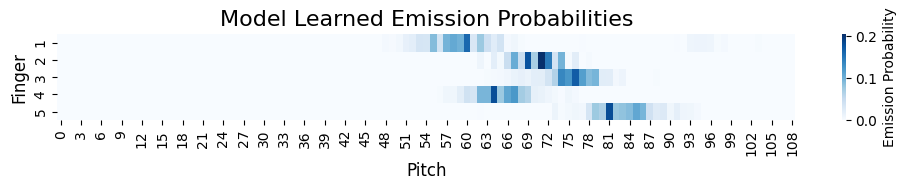

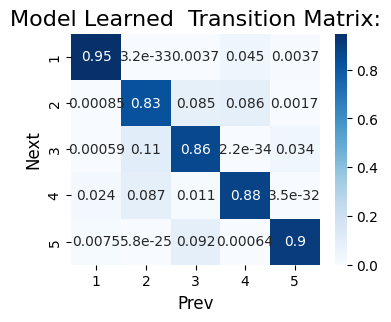

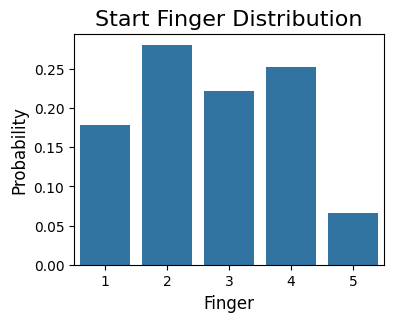

In [11]:
#@title Model Learned Parameters

plt.figure(figsize=(10, 2))
cmap = plt.get_cmap("Blues")
cmap.set_bad(color='white')

heatmap = sns.heatmap(
    model.emissionprob_,
    cmap=cmap,
    cbar_kws={'label': 'Emission Probability'},
    yticklabels=np.arange(1, 6)
)
plt.title('Model Learned Emission Probabilities', fontsize=16)
plt.xlabel('Pitch', fontsize=12)
plt.ylabel('Finger', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 3))
sns.heatmap(model.transmat_, annot=True,  cmap='Blues', xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
plt.title('Model Learned  Transition Matrix:', fontsize=16)
plt.xlabel('Prev', fontsize=12)
plt.ylabel('Next', fontsize=12)
plt.show()


plt.figure(figsize=(4, 3))
bar_plot = sns.barplot(
  x = [1, 2, 3, 4, 5],
  y = model.startprob_
)

plt.title('Start Finger Distribution', fontsize=16)
plt.xlabel('Finger', fontsize=12)
plt.ylabel('Probability', fontsize=12)

plt.show()


--- HMM Model Evaluation Results ---
Log-Likelihood of the Test Set: -inf

Total notes in test set: 3632
Notes used for accuracy (finger != 0): 1915

Overall Accuracy: 21.46%

Classification Report:
              precision    recall  f1-score   support

    Finger 1       0.32      0.11      0.17       510
    Finger 2       0.20      0.28      0.23       396
    Finger 3       0.26      0.38      0.31       392
    Finger 4       0.16      0.19      0.17       369
    Finger 5       0.14      0.09      0.11       248

    accuracy                           0.21      1915
   macro avg       0.22      0.21      0.20      1915
weighted avg       0.23      0.21      0.20      1915



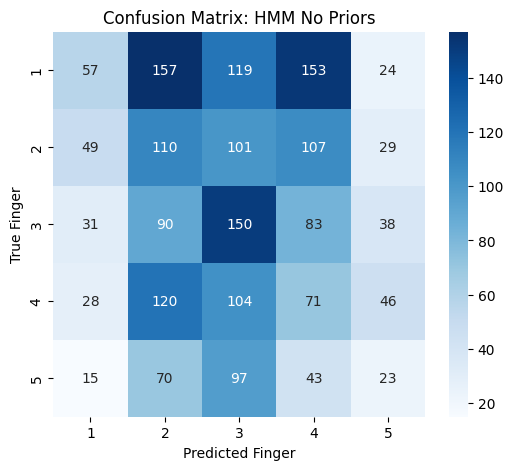

In [12]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Get the log-likelihood of the test set
# This measures how well the model fits the data. Higher (less negative) is better.
log_likelihood = model.score(X_test, test_lengths)

# Predict the hidden states (fingers) for the test set
# The model outputs states from 0-4.
predicted_states = model.predict(X_test, test_lengths)

# Convert the HMM's predicted states (0-4) to finger labels (1-5)
predicted_fingers = predicted_states + 1


# Create a boolean mask to select only the samples where the true finger is not 0.
mask = y_test_true_flat != 0
filtered_predictions = predicted_fingers[mask]
filtered_true_labels = y_test_true_flat[mask]

accuracy = accuracy_score(filtered_true_labels, filtered_predictions)


class_report = classification_report(
    filtered_true_labels,
    filtered_predictions,
    target_names=[f'Finger {i}' for i in range(1, 6)]
)


conf_matrix = confusion_matrix(filtered_true_labels, filtered_predictions)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f'True F{i}' for i in range(1, 6)],
    columns=[f'Pred F{i}' for i in range(1, 6)]
)


print("\n--- HMM Model Evaluation Results ---")
print(f"Log-Likelihood of the Test Set: {log_likelihood:.2f}")
print(f"\nTotal notes in test set: {len(y_test_true_flat)}")
print(f"Notes used for accuracy (finger != 0): {len(filtered_true_labels)}")
print(f"\nOverall Accuracy: {accuracy:.2%}")

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
plt.title('Confusion Matrix: HMM No Priors')
plt.xlabel('Predicted Finger')
plt.ylabel('True Finger')
plt.show()

In [13]:
# Second verion of the model *with* priors
model = hmm.CategoricalHMM(n_components=5, n_iter=1000, tol=1e-4, random_state=17,init_params = '', params = '', verbose=True)
model.transmat_ = transmat_prior
model.startprob_ = startprob_prior
model.emissionprob_ = emissionprob_prior

# Train the HMM model
print("Training the Hidden Markov Model...")
model.fit(X_train, train_lengths)

Training the Hidden Markov Model...


         1  -39326.01067410             +nan
         2  -39326.01067410      +0.00000000


CategoricalHMM(init_params='', n_components=5, n_features=np.int64(109),
               n_iter=1000, params='',
               random_state=RandomState(MT19937) at 0x7BBEAF88FA40, tol=0.0001,
               verbose=True)

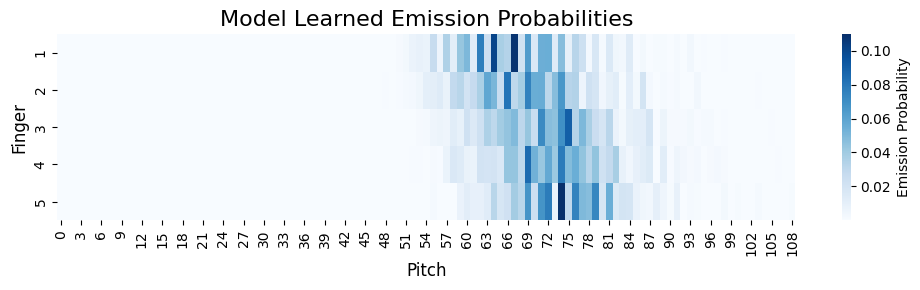

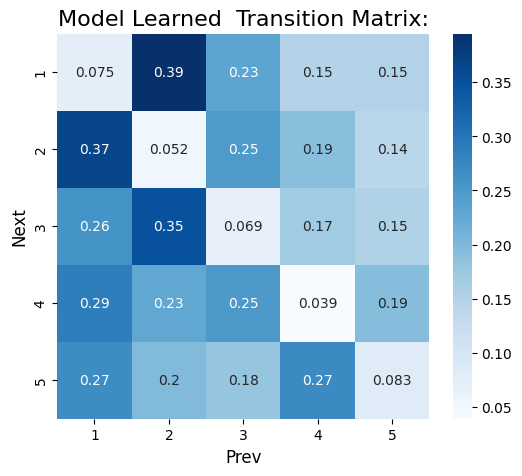

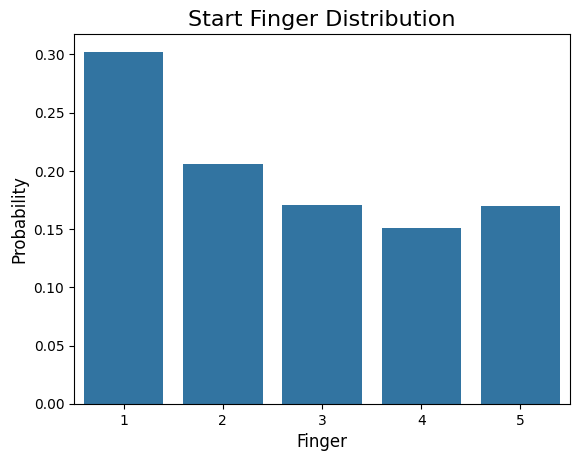

In [14]:
#@title Model Learned Parameters

plt.figure(figsize=(10, 3))
cmap = plt.get_cmap("Blues")
cmap.set_bad(color='white')

heatmap = sns.heatmap(
    model.emissionprob_,
    cmap=cmap,
    cbar_kws={'label': 'Emission Probability'},
    yticklabels=np.arange(1, 6)
)
plt.title('Model Learned Emission Probabilities', fontsize=16)
plt.xlabel('Pitch', fontsize=12)
plt.ylabel('Finger', fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
sns.heatmap(model.transmat_, annot=True,  cmap='Blues', xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
plt.title('Model Learned  Transition Matrix:', fontsize=16)
plt.xlabel('Prev', fontsize=12)
plt.ylabel('Next', fontsize=12)
plt.show()


bar_plot = sns.barplot(
  x = [1, 2, 3, 4, 5],
  y = model.startprob_
)

plt.title('Start Finger Distribution', fontsize=16)
plt.xlabel('Finger', fontsize=12)
plt.ylabel('Probability', fontsize=12)

plt.show()


--- HMM Model Evaluation Results ---
Log-Likelihood of the Test Set: -12499.32

Total notes in test set: 3632
Notes used for accuracy (finger != 0): 1915

Overall Accuracy: 36.66%

Classification Report:
              precision    recall  f1-score   support

    Finger 1       0.45      0.54      0.49       510
    Finger 2       0.32      0.55      0.40       396
    Finger 3       0.40      0.24      0.30       392
    Finger 4       0.30      0.16      0.21       369
    Finger 5       0.29      0.21      0.25       248

    accuracy                           0.37      1915
   macro avg       0.35      0.34      0.33      1915
weighted avg       0.36      0.37      0.35      1915



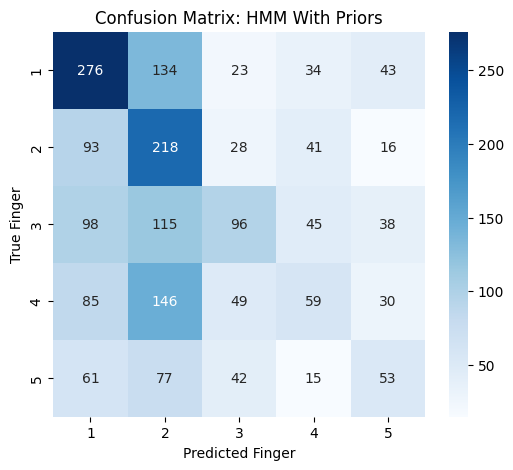

In [16]:
# Get the log-likelihood of the test set
# This measures how well the model fits the data. Higher (less negative) is better.
log_likelihood = model.score(X_test, test_lengths)

# Predict the hidden states (fingers) for the test set
# The model outputs states from 0-4.
predicted_states = model.predict(X_test, test_lengths)

# Convert the HMM's predicted states (0-4) to finger labels (1-5)
predicted_fingers = predicted_states + 1


# Create a boolean mask to select only the samples where the true finger is not 0.
mask = y_test_true_flat != 0
filtered_predictions = predicted_fingers[mask]
filtered_true_labels = y_test_true_flat[mask]

accuracy = accuracy_score(filtered_true_labels, filtered_predictions)


class_report = classification_report(
    filtered_true_labels,
    filtered_predictions,
    target_names=[f'Finger {i}' for i in range(1, 6)]
)


conf_matrix = confusion_matrix(filtered_true_labels, filtered_predictions)
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=[f'True F{i}' for i in range(1, 6)],
    columns=[f'Pred F{i}' for i in range(1, 6)]
)


print("\n--- HMM Model Evaluation Results ---")
print(f"Log-Likelihood of the Test Set: {log_likelihood:.2f}")
print(f"\nTotal notes in test set: {len(y_test_true_flat)}")
print(f"Notes used for accuracy (finger != 0): {len(filtered_true_labels)}")
print(f"\nOverall Accuracy: {accuracy:.2%}")

print("\nClassification Report:")
print(class_report)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 6), yticklabels=np.arange(1, 6))
plt.title('Confusion Matrix: HMM With Priors')
plt.xlabel('Predicted Finger')
plt.ylabel('True Finger')
plt.show()

## Results

The results demonstrate that initializing the HMM with well-estimated priors is crucial. However, even with this improvement, the HMM's accuracy of 36.5% falls significantly short of the 86% achieved by the Random Forest baseline due to several factors:
.

1.   The Markov Assumption: The HMM assumes that the choice of the current finger only depends on the previous finger. This is a significant oversimplification. Pianists make decisions based on the context of several preceding and upcoming notes to optimize hand position.
2.   Feature Representation: The HMM uses only a single feature for its observations—the MIDI pitch. In contrast, Random Forest was engineered with features representing a window of four previous notes and two upcoming notes (both pitch and finger), providing it with much richer context.
3.   Generative vs. Discriminative: The HMM is a generative model that learns the joint probability distribution P(fingers, notes). The Random Forest is a discriminative model that directly learns the conditional probability P(finger | notes). For a classification task like this, a discriminative approach is often more effective.

Potential directions for future work:


*   Richer Observation Features: Expanding the HMM's observation vector to include features like the interval to the next note, note duration, or whether a note is part of a chord.
*   Higher-Order HMMs: Using a second-order HMM, where the current state depends on the two previous states, could capture more of the necessary musical context.
*   Hybrid Approaches: Combining the probabilistic sequencing of an HMM with the predictive power of a neural network (e.g., using an RNN to output emission probabilities) could potentially yield superior results.




